<a href="https://colab.research.google.com/github/zzoeys/freecakefridays/blob/main/precinct_polling_sites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install descartes
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install pandas

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 52.8 MB/s 
     |████████████████████████████████| 6.3 MB 64.4 MB/s 


Import the required libraries.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

This step reads the prepared precinct data with the racial data and whether a precinct has a polling site or not in a CSV format and extracts the last 11 digits of the geographical ID which helps merge the data.

In [ ]:
poll = pd.read_csv('/content/clean_precincts_with_polling_site.csv')
poll.id=poll['id'].str.slice(start=-11)
poll.head()

,Unnamed: 0,Area Name,id,Total,Hispanic,White,Black,Asian,Mixed,Others,Population Density: Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,Polling Site
0,0,"2, Appling County, Georgia",13001000002,3563.0,403.0,1215.0,1838.0,10.0,81.0,16.0,0.113107,0.341005,0.515857,0.002807,0.022734,0.004491,1
1,1,"1B, Appling County, Georgia",1300100001B,1834.0,76.0,1575.0,109.0,3.0,63.0,8.0,0.041439,0.858779,0.059433,0.001636,0.034351,0.004362,1
2,2,"1C, Appling County, Georgia",1300100001C,1538.0,116.0,1242.0,150.0,5.0,25.0,0.0,0.075423,0.807542,0.097529,0.003251,0.016255,0.000000,1
3,3,"3C, Appling County, Georgia",1300100003C,2515.0,263.0,1528.0,608.0,39.0,69.0,8.0,0.104573,0.607555,0.241750,0.015507,0.027435,0.003181,1
4,4,"4B, Appling County, Georgia",1300100004B,1321.0,62.0,1147.0,59.0,5.0,43.0,5.0,0.046934,0.868282,0.044663,0.003785,0.032551,0.003785,1


This step reads the geodataframe which is in a shapefile format.

In [ ]:
geoData = "/content/cb_2020_13_vtd_500k.shp"
precinct = gpd.read_file(geoData)
precinct

,STATEFP20,COUNTYFP20,VTDST20,AFFGEOID20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,ALAND20,AWATER20,geometry
0,13,089,0000MN,7000000US130890000MN,130890000MN,A,Memorial South,Memorial South,00,2870732,0,"POLYGON ((-84.23640 33.79579, -84.22852 33.795..."
1,13,015,000016,7000000US13015000016,13015000016,A,ZENA DRIVE,ZENA DRIVE,00,34588806,109680,"MULTIPOLYGON (((-84.77603 34.18687, -84.77592 ..."
2,13,121,0SS13A,7000000US131210SS13A,131210SS13A,A,SS13A,SS13A,00,1380349,4961,"POLYGON ((-84.38070 33.88620, -84.38077 33.887..."
3,13,097,000733,7000000US13097000733,13097000733,A,ARBOR STATION,ARBOR STATION,00,4737675,0,"POLYGON ((-84.76529 33.71717, -84.76474 33.718..."
4,13,063,00RD02,7000000US1306300RD02,1306300RD02,A,RIVERDALE 2,RIVERDALE 2,00,3543893,121558,"POLYGON ((-84.43945 33.55072, -84.43184 33.550..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2693,13,297,000423,7000000US13297000423,13297000423,A,BROKEN ARROW,BROKEN ARROW,00,37330235,182413,"POLYGON ((-83.91749 33.75357, -83.91499 33.755..."
2694,13,051,03-15C,7000000US1305103-15C,1305103-15C,A,ELI WHITNEY COMPLEX,ELI WHITNEY COMPLEX,00,9453851,1741591,"POLYGON ((-81.05333 32.07291, -81.05079 32.077..."
2695,13,195,000HUL,7000000US13195000HUL,13195000HUL,A,HULL,HULL,00,55981132,628672,"POLYGON ((-83.35848 34.04162, -83.35655 34.042..."
2696,13,141,00001A,7000000US1314100001A,1314100001A,A,DEVEREUX FIRE STATION,DEVEREUX FIRE STATION,00,157090464,6809617,"POLYGON ((-83.27522 33.19132, -83.27413 33.196..."


This step merges the geodataframe and the CSV dataframe. It merges on the geographical ID.

In [ ]:
complete = precinct.merge(poll, how='left', left_on='GEOID20', right_on='id')
complete.head()

,STATEFP20,COUNTYFP20,VTDST20,AFFGEOID20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,ALAND20,AWATER20,geometry,Unnamed: 0,Area Name,id,Total,Hispanic,White,Black,Asian,Mixed,Others,Population Density: Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,Polling Site
0,13,089,0000MN,7000000US130890000MN,130890000MN,A,Memorial South,Memorial South,00,2870732,0,"POLYGON ((-84.23640 33.79579, -84.22852 33.795...",868,"Memorial South, DeKalb County, Georgia",130890000MN,4773.0,206.0,218.0,3933.0,252.0,130.0,34.0,0.043159,0.045674,0.824010,0.052797,0.027237,0.007123,0
1,13,015,000016,7000000US13015000016,13015000016,A,ZENA DRIVE,ZENA DRIVE,00,34588806,109680,"MULTIPOLYGON (((-84.77603 34.18687, -84.77592 ...",76,"ZENA DRIVE, Bartow County, Georgia",13015000016,10158.0,1248.0,6028.0,2152.0,221.0,432.0,77.0,0.122859,0.593424,0.211853,0.021756,0.042528,0.007580,1
2,13,121,0SS13A,7000000US131210SS13A,131210SS13A,A,SS13A,SS13A,00,1380349,4961,"POLYGON ((-84.38070 33.88620, -84.38077 33.887...",1540,"SS13A, Fulton County, Georgia",131210SS13A,3260.0,790.0,1849.0,387.0,146.0,71.0,17.0,0.242331,0.567178,0.118712,0.044785,0.021779,0.005215,1
3,13,097,000733,7000000US13097000733,13097000733,A,ARBOR STATION,ARBOR STATION,00,4737675,0,"POLYGON ((-84.76529 33.71717, -84.76474 33.718...",1004,"ARBOR STATION, Douglas County, Georgia",13097000733,4359.0,534.0,1316.0,2163.0,96.0,184.0,66.0,0.122505,0.301904,0.496215,0.022023,0.042212,0.015141,1
4,13,063,00RD02,7000000US1306300RD02,1306300RD02,A,RIVERDALE 2,RIVERDALE 2,00,3543893,121558,"POLYGON ((-84.43945 33.55072, -84.43184 33.550...",468,"RIVERDALE 2, Clayton County, Georgia",1306300RD02,5449.0,962.0,162.0,4124.0,64.0,104.0,33.0,0.176546,0.029730,0.756836,0.011745,0.019086,0.006056,1


This step visualizes which precincts have and don't have a polling site. Precincts represented by dark blue have a polling site. Precincts represented by white do not have a polling site.

The method for developing choropleth maps was further learned from the following source: [(Linggar, 2019)](https://towardsdatascience.com/a-beginners-guide-to-create-a-cloropleth-map-in-python-using-geopandas-and-matplotlib-9cc4175ab630)

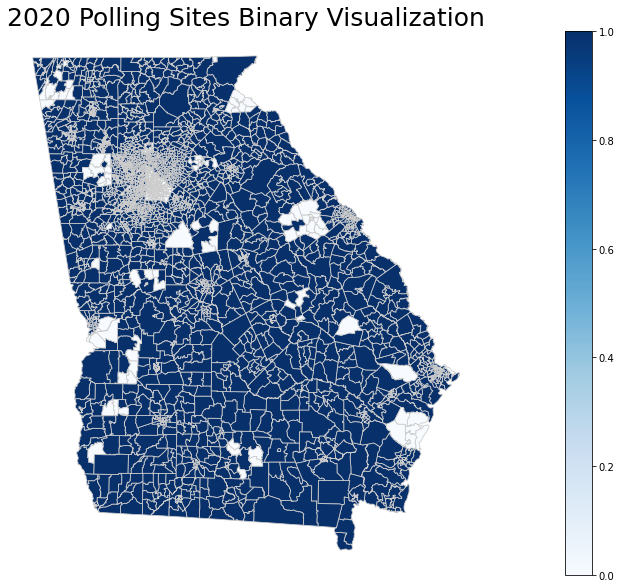

In [ ]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('2020 Polling Sites Binary Visualization', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues')
colorbar=fig.colorbar(sm)
complete.plot(column='Polling Site', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=1)

A function is defined to calculate the center point of a polygon shape. This means that the center point of a county is calculated from the 'geometry' column. This process converts to the polygon geometry to a planar coordinate reference system (CRS), calculates the centroid point, and then converts the point back to the original CRS which is the CRS of the 'complete' dataframe.

This function defines where the points will be located on the scatter map. The method for developing scatter maps is from the following source: [(Coderzcolumn.com., 2021)](https://coderzcolumn.com/tutorials/data-science/geoplot-scatter-and-bubble-maps-python)

In [ ]:
def calculate_center(df):

    original_crs = complete.crs
    planar_crs = 'EPSG:3857'
    return complete['geometry'].to_crs(planar_crs).centroid.to_crs(original_crs)

complete["center"] = calculate_center(complete)

complete.head()

,STATEFP20,COUNTYFP20,VTDST20,AFFGEOID20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,ALAND20,AWATER20,geometry,Unnamed: 0,Area Name,id,Total,Hispanic,White,Black,Asian,Mixed,Others,Population Density: Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,Polling Site,center
0,13,089,0000MN,7000000US130890000MN,130890000MN,A,Memorial South,Memorial South,00,2870732,0,"POLYGON ((-84.23640 33.79579, -84.22852 33.795...",868,"Memorial South, DeKalb County, Georgia",130890000MN,4773.0,206.0,218.0,3933.0,252.0,130.0,34.0,0.043159,0.045674,0.824010,0.052797,0.027237,0.007123,0,POINT (-84.22192 33.79289)
1,13,015,000016,7000000US13015000016,13015000016,A,ZENA DRIVE,ZENA DRIVE,00,34588806,109680,"MULTIPOLYGON (((-84.77603 34.18687, -84.77592 ...",76,"ZENA DRIVE, Bartow County, Georgia",13015000016,10158.0,1248.0,6028.0,2152.0,221.0,432.0,77.0,0.122859,0.593424,0.211853,0.021756,0.042528,0.007580,1,POINT (-84.78113 34.20829)
2,13,121,0SS13A,7000000US131210SS13A,131210SS13A,A,SS13A,SS13A,00,1380349,4961,"POLYGON ((-84.38070 33.88620, -84.38077 33.887...",1540,"SS13A, Fulton County, Georgia",131210SS13A,3260.0,790.0,1849.0,387.0,146.0,71.0,17.0,0.242331,0.567178,0.118712,0.044785,0.021779,0.005215,1,POINT (-84.37490 33.88789)
3,13,097,000733,7000000US13097000733,13097000733,A,ARBOR STATION,ARBOR STATION,00,4737675,0,"POLYGON ((-84.76529 33.71717, -84.76474 33.718...",1004,"ARBOR STATION, Douglas County, Georgia",13097000733,4359.0,534.0,1316.0,2163.0,96.0,184.0,66.0,0.122505,0.301904,0.496215,0.022023,0.042212,0.015141,1,POINT (-84.74940 33.72112)
4,13,063,00RD02,7000000US1306300RD02,1306300RD02,A,RIVERDALE 2,RIVERDALE 2,00,3543893,121558,"POLYGON ((-84.43945 33.55072, -84.43184 33.550...",468,"RIVERDALE 2, Clayton County, Georgia",1306300RD02,5449.0,962.0,162.0,4124.0,64.0,104.0,33.0,0.176546,0.029730,0.756836,0.011745,0.019086,0.006056,1,POINT (-84.42763 33.53465)


This step creates a dataframe which drops the original 'geometry' column of the 'complete' dataframe, and renames the 'center' column to 'geometry'. This means that the geodataframe recognizes the centroid point as the 'geometry' of the precinct. This center point is where the points will be located on the bubble map. Then, only the rows which have a polling site are extracted by filtering and keeping only the rows which have a polling site value of '1'.

In [ ]:
bubble = complete.drop(columns=["geometry"]).rename(columns={"center": "geometry"})
bubble = bubble[bubble['Polling Site'] == 1]

bubble.head()

,STATEFP20,COUNTYFP20,VTDST20,AFFGEOID20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,ALAND20,AWATER20,Unnamed: 0,Area Name,id,Total,Hispanic,White,Black,Asian,Mixed,Others,Population Density: Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,Polling Site,geometry
1,13,015,000016,7000000US13015000016,13015000016,A,ZENA DRIVE,ZENA DRIVE,00,34588806,109680,76,"ZENA DRIVE, Bartow County, Georgia",13015000016,10158.0,1248.0,6028.0,2152.0,221.0,432.0,77.0,0.122859,0.593424,0.211853,0.021756,0.042528,0.007580,1,POINT (-84.78113 34.20829)
2,13,121,0SS13A,7000000US131210SS13A,131210SS13A,A,SS13A,SS13A,00,1380349,4961,1540,"SS13A, Fulton County, Georgia",131210SS13A,3260.0,790.0,1849.0,387.0,146.0,71.0,17.0,0.242331,0.567178,0.118712,0.044785,0.021779,0.005215,1,POINT (-84.37490 33.88789)
3,13,097,000733,7000000US13097000733,13097000733,A,ARBOR STATION,ARBOR STATION,00,4737675,0,1004,"ARBOR STATION, Douglas County, Georgia",13097000733,4359.0,534.0,1316.0,2163.0,96.0,184.0,66.0,0.122505,0.301904,0.496215,0.022023,0.042212,0.015141,1,POINT (-84.74940 33.72112)
4,13,063,00RD02,7000000US1306300RD02,1306300RD02,A,RIVERDALE 2,RIVERDALE 2,00,3543893,121558,468,"RIVERDALE 2, Clayton County, Georgia",1306300RD02,5449.0,962.0,162.0,4124.0,64.0,104.0,33.0,0.176546,0.029730,0.756836,0.011745,0.019086,0.006056,1,POINT (-84.42763 33.53465)
6,13,121,00AP03,7000000US1312100AP03,1312100AP03,A,AP03,AP03,00,1161361,0,1329,"AP03, Fulton County, Georgia",1312100AP03,1510.0,647.0,312.0,465.0,24.0,50.0,12.0,0.428477,0.206623,0.307947,0.015894,0.033113,0.007947,1,POINT (-84.32516 34.03925)


This step uses the Seaborn library to develop a colormap of blue to red.

The method to develop the required scale using the Seaborn library was learned from the following source: [(Seaborn.pydata.org., 2020)](https://seaborn.pydata.org/generated/seaborn.diverging_palette.html#seaborn.diverging_palette)


In [ ]:
redblue = sns.diverging_palette(10, 240, center='light', as_cmap=True)

This step plots a scatter map of which precincts have a polling site over a bivariate choropleth map representing the white and black racial density.

The method for developing bivariate choropleth maps was learned from the following source: [(Campus.datacamp.com., 2019)](https://campus.datacamp.com/courses/analyzing-us-census-data-in-python/american-community-survey?ex=12)

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


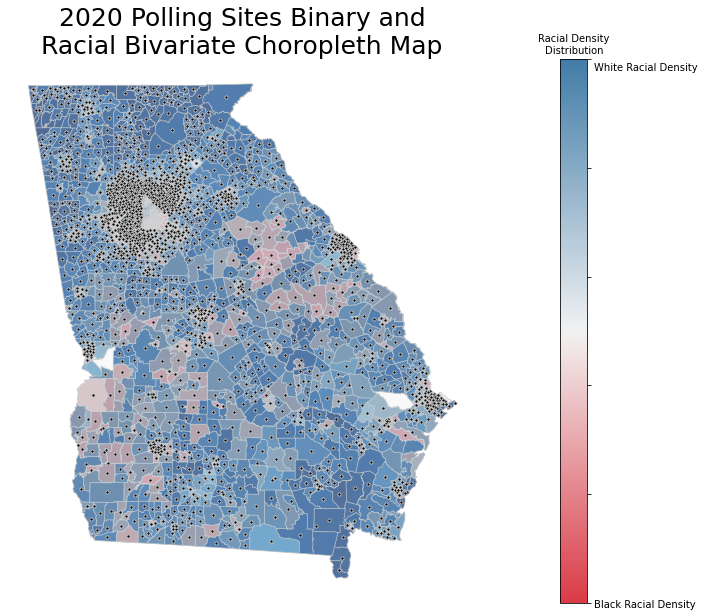

In [ ]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('2020 Polling Sites Binary and\nRacial Bivariate Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap=redblue)
colorbar=fig.colorbar(sm)
colorbar.ax.set_title('Racial Density\nDistribution',fontsize=10)
colorbar.ax.set_yticklabels(['Black Racial Density', '', '', '', '', '\nWhite Racial Density'])
complete.plot(column='Population Density: Black', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=1)
complete.plot(column='Population Density: White', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
bubble.plot(column='Polling Site', marker='o', color='black', markersize=10, linewidth=0.8, ax=ax, edgecolor='0.8')

Citations

Linggar, R., 2019. A Beginners Guide to Create a Cloropleth Map in Python using GeoPandas and Matplotlib. [online] Towards Data Science. Available at: https://towardsdatascience.com/a-beginners-guide-to-create-a-cloropleth-map-in-python-using-geopandas-and-matplotlib-9cc4175ab630 [Accessed 1 November 2021].


Coderzcolumn.com. 2021. Geoplot - Scatter & Bubble Maps [Python] by Sunny Solanki. [online] Available at: https://coderzcolumn.com/tutorials/data-science/geoplot-scatter-and-bubble-maps-python [Accessed 8 December 2021].


Seaborn.pydata.org. 2020. seaborn.diverging_palette — seaborn 0.11.2 documentation. [online] Available at: https://seaborn.pydata.org/generated/seaborn.diverging_palette.html#seaborn.diverging_palette [Accessed 1 January 2022].


Campus.datacamp.com. 2019. Bivariate Map of Broadband Access | Python. [online] Available at: https://campus.datacamp.com/courses/analyzing-us-census-data-in-python/american-community-survey?ex=12 [Accessed 4 December 2021].